In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neuron
from neuron import h, rxd,nrn
from neuron.units import ms, mV  #explicitly define our units
import math as m
from scipy.signal import find_peaks
import pandas as pd

In [2]:
#Include new mechanisms for additional channels 

h.nrn_load_dll('C:\\nrn\\Mod Files\\nrnmech.dll')

#h.load_file("nrnmech.dll")
h.load_file('stdrun.hoc') #loads in Neurons running domain

1.0

In [3]:
class Cortical_Neuron():
    # Class to create cortical neuron with relevant mechanisms and morphology

    def __init__(self, Total_length=32731, M_diam= 1.4, N_diam = 1.2, int_length=500, m0_L = 80):  # allow myelin and node diameter to be set each time
        # Create topology
        # self.connect = connect
        # self.connection_node = connection_node
        node_num = (Total_length - 20 - m0_L + int_length) / (int_length + 2) #determing the requied node number based on the constant length
        # Check if n is an integer, if not round appropriately
        n_rounded = round(node_num)
        if node_num != n_rounded:
            print(f"Rounded node number from {node_num} to {n_rounded}. Adjust lengths or total length accordingly.")
            Adj_length= 20 + m0_L  +  int_length* n_rounded + n_rounded * 2
            print(f"Length adjusted from {Total_length} to {Adj_length}.")
        node_num = n_rounded
        
        # Output the number of nodes
        print(f"The number of nodes n is: {node_num}")
        
        self.node_num = node_num
        self.nodes = []
        self.myelins = []
        for i in range(node_num):
            self.nodes.append(h.Section(name=f"Node_{i}"))  # Create sections with names corresponding to nodes Node_0 Node_1
            self.myelins.append(h.Section(name=f"Myelins_{i}"))

        self.ais = h.Section(name='ais')
        self.collateral = h.Section(name='collateral')

        # Connect nodes and myelin into one long axon
        for i in range(node_num-1):
            self.nodes[i].connect(self.myelins[i], 1, 0)
            self.myelins[i+1].connect(self.nodes[i], 1, 0)

        self.nodes[node_num-1].connect(self.myelins[node_num-1], 1, 0)
        self.myelins[0].connect(self.ais, 1, 0)
        # if connect == 1:
        #     self.collateral.connect(self.nodes[connection_node], 0.5, 0)

        # Initialise parameters
        Ena = 60
        Ek = -90
        v_init = -68
        rm = 30000
        celsius = 37
        ra = 150
        c_m = 0.8

        #Storing vectors 
        self.V_c_vectors = {} # Store collateral voltage vectors
        self.V_a_vectors = {}  # Store axon voltage vectors
        self.V_ais_vectors = {} # Store AIS voltage vectors
        self.Ext_potential = {} # Store collateral extracellular potential vectors
        self.Firing_Counter_Collateral = [] # Store collateral firing count vectors
        self.Firing_Times_Collateral = []
        self.Firing_Count_Collateral = []
        self.Firing_Counter_Axon = []
        self.Firing_Times_Axon = []
        self.Firing_Count_Axon = []
        self.Firing_Counter_AIS = []
        self.Firing_Times_AIS = []
        self.Firing_Count_AIS = []
        
        # Insert mechanisms and define geometries
        for n in self.nodes:
            n.L = 2
            n.diam = N_diam
            n.Ra = ra
            n.insert('cortical_axon_i_kd')
            n.insert('cortical_axon_i_kv')
            n.insert("cortical_axon_i_na")
            n.insert('cortical_axon_i_leak')
            n.insert(h.extracellular)
            #n.insert(h.APCount)
            n.g_Na_cortical_axon_i_na = 0.28
            n.g_Kd_cortical_axon_i_kd = 0.0072
            n.g_Kv_cortical_axon_i_kv = 0.0005
            n.g_l_cortical_axon_i_leak = 0.02
            n.ek = Ek
            n.ena = Ena
            n.cm = c_m
            n.nseg = 5

        for m in self.myelins:
            m.L = int_length
            m.diam = M_diam
            m.Ra = ra
            m.cm = 0.04
            m.nseg = 11
            m.insert('cortical_axon_i_na')
            m.insert('cortical_axon_i_leak')
            m.g_Na_cortical_axon_i_na = 0.001
            m.g_l_cortical_axon_i_leak = 0
            m.ena = Ena
        self.myelins[0].L = m0_L


        self.ais.L = 20
        self.ais.nseg = 5
        self.ais.diam = N_diam
        self.ais.insert('cortical_axon_i_na')
        self.ais.insert('cortical_axon_i_kv')
        self.ais.insert('cortical_axon_i_kd')
        self.ais.insert('cortical_axon_i_leak')
        self.ais.insert(h.extracellular)
        self.ais.g_Kv_cortical_axon_i_kv = 0.002
        self.ais.g_Na_cortical_axon_i_na = 0.4
        self.ais.g_Kd_cortical_axon_i_kd = 0.015
        self.ais.g_l_cortical_axon_i_leak = 0.000033
        self.ais.Ra = ra
        self.ais.cm = c_m
        self.ais.ek = Ek
        self.ais.ena = Ena

    

    @staticmethod
    def Euclidean(x1, x2, y1, y2):
        return m.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    def Coordinates(self, Electrode_X_d, Electrode_Y_d):
    
        # Axon Coords
        y_coords_A = []
        for n in range(self.node_num):
            if n == 0:
                y_coords_A.append(20 +m0_L+ 1)  # AIS + Myelin[0] + midpoint of node 0
            else:
                y_coords_A.append(20 +m0_L +  int_length* n + n * 2 + 1)  # AIS + initial myelin + num_myelin x n + nodes x node_length + 1 for centre of that node

        Node_radius = (self.nodes[0].diam) / 2
        X_A = Node_radius  # x coordinate of axon is radius of node
        r_A = []  # euclidean distance for the axon

        for n in range(self.node_num):
            r_A.append(Cortical_Neuron.Euclidean(X_A, Electrode_X_d, y_coords_A[n], Electrode_Y_d))

        # # Collateral Coords
        # x_coords_C = []
        # C_L = self.collateral.L
        # Nseg_C = self.collateral.nseg
        # for seg in range(Nseg_C):
        #     x_coords_C.append((seg / Nseg_C) * C_L + Node_radius)  # collateral length

        # Collateral_YPosition = 100 + 500 * self.connection_node + self.connection_node * 2 + 1  # assume collateral attached at the centre of the node - 15
        # r_C = []
        # for seg in range(Nseg_C):
        #     r_C.append(Cortical_Neuron.Euclidean(x_coords_C[seg], Electrode_X_d, Collateral_YPosition, Electrode_Y_d))

        # AIS coords
        Nseg_AIS  = self.ais.nseg
        AIS_L = self.ais.L
        X_AIS = Node_radius
        y_coords_AIS = []
        for seg in range(Nseg_AIS):
            y_coords_AIS.append((seg / Nseg_AIS) * AIS_L)

        r_AIS = []
        for seg in range(Nseg_AIS):
            r_AIS.append(Cortical_Neuron.Euclidean(X_AIS, Electrode_X_d, y_coords_AIS[seg], Electrode_Y_d))
            
        # conversion factor
        for i in range(len(r_A)):
            r_A[i] *= 10**-6

        # for i in range(len(r_C)):
        #     r_C[i] *= 10**-6

        for i in range(len(r_AIS)):
            r_AIS[i] *= 10**-6
            
        return r_A, r_AIS, y_coords_A, Node_radius, Electrode_X_d, Electrode_Y_d

    # def Plot_Geometry(self, Electrode_X_d=1500, Electrode_Y_d=521):
    #     [r_A, r_AIS, y_coords_A, Node_radius, Electrode_X_d, Electrode_Y_d] = self.Coordinates(Electrode_X_d, Electrode_Y_d)
    #     # Plot coordinates of Electrode, collateral and axon with respect to y and x axis:
    #     # y_coords_C = []
    #     x_coords_A = []
    #     # for i in range(len(x_coords_C)):
    #     #     y_coords_C.append(Collateral_YPosition)
    #     print(f"Max y value is {max(y_coords_A)}")
    #     for i in range(len(y_coords_A)):
    #         x_coords_A.append(Node_radius)
    #     print(y_coords_A[-1])
    #     stim_x = Electrode_X_d
    #     stim_y = Electrode_Y_d
    #     #plt.plot(x_coords_C, y_coords_C, '--', color='red', label='Collateral Position')
    #     plt.plot(x_coords_A, y_coords_A, color='blue', label='Axon Position')
    #     plt.plot(stim_x, stim_y, '*', color='black', label='Electrode Position')
    #     plt.title('Relative Position of Axon and Electrode')
    #     plt.xlabel('X (um)')
    #     plt.ylabel('Y (um)')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()

    def Extracellular(self, amp_A, delay, pulse_dur, total_dur, Electrode_X_d=1500, Electrode_Y_d=521):
        [r_A, r_AIS, y_coords_A, Node_radius, Electrode_X_d, Electrode_Y_d] = self.Coordinates(Electrode_X_d, Electrode_Y_d)
        pi = 3.141
        sigma = 0.2  # S/m
        Phi_A = []
        for i in range(len(r_A)):
            Phi_A.append((amp_A / (r_A[i] * sigma * pi * 4))*10**3)

        # Phi_C = []
        # for i in range(len(r_C)):
        #     Phi_C.append((amp_C / (r_C[i] * sigma * pi * 4))*10**3)

        Phi_AIS = []
        for i in range(len(r_AIS)):
            Phi_AIS.append((amp_A / (r_AIS[i] * sigma * pi * 4))*10**3)


        # Time vector
        t0 = 0
        t1 = delay
        t2 =delay
        t3 = delay + pulse_dur
        t4 = delay + pulse_dur
        t5 = total_dur  # 15ms
        stimtvec_list_A = [t0, t1, t2, t3, t4, t5]
        stimtvec_A = h.Vector(stimtvec_list_A)

        # stimtvec_list_C = [t0, t1, t2, t3, t4, t5]
        # stimtvec_C = h.Vector(stimtvec_list_C)

        stimtvec_list_AIS = [t0, t1, t2, t3, t4, t5]
        stimtvec_AIS = h.Vector(stimtvec_list_AIS)

        # Play in ex mechanisms

        # #Collateral
        # Nseg_C = self.collateral.nseg
        # ampvec_allnodes_C = []
        # for i in range(Nseg_C):
        #     loc = i / Nseg_C
        #     stimampvec_list_C = [0, 0, Phi_C[i], Phi_C[i], 0, 0]
        #     ampvec_allnodes_C.append(h.Vector(stimampvec_list_C))
        #     ampvec_allnodes_C[-1].play(self.collateral(loc)._ref_e_extracellular, stimtvec_C, True)
        #    # print(f"{i}: {stimampvec_list_C}")

        #Axon
        ampvec_allnodes_A = []
        for n in range(self.node_num):
            stimampvec_list_A = [0, 0, Phi_A[n], Phi_A[n], 0, 0]
            ampvec_allnodes_A.append(h.Vector(stimampvec_list_A))
            ampvec_allnodes_A[-1].play(self.nodes[n](0.5)._ref_e_extracellular, stimtvec_A, True)
            #print(f"{n}: {stimampvec_list_A}")
        


        #AIS
        Nseg_AIS  = self.ais.nseg
        ampvec_allnodes_AIS = []
        for i in range(Nseg_AIS):
            loc = i / Nseg_AIS
            stimampvec_list_AIS = [0, 0, Phi_AIS[i], Phi_AIS[i], 0, 0]
            ampvec_allnodes_AIS.append(h.Vector(stimampvec_list_AIS))
            ampvec_allnodes_AIS[-1].play(self.ais(loc)._ref_e_extracellular, stimtvec_AIS, True)

        return ampvec_allnodes_A, ampvec_allnodes_AIS, stimtvec_A, stimtvec_AIS

    def Plot_Geometry(self, Electrode_X_d=1500, Electrode_Y_d=521):
        [r_A, r_AIS, y_coords_A, Node_radius, Electrode_X_d, Electrode_Y_d] = self.Coordinates(Electrode_X_d, Electrode_Y_d)
        # Plot coordinates of Electrode, collateral and axon with respect to y and x axis:
        
        x_coords_A = []

        for i in range(len(y_coords_A)):
            x_coords_A.append(Node_radius)
        print(f"Max y value is {max(y_coords_A)}")
        stim_x = Electrode_X_d
        stim_y = Electrode_Y_d
        #plt.plot(x_coords_C, y_coords_C, '--', color='red', label='Collateral Position')
        plt.plot(x_coords_A, y_coords_A, color='blue', label='Axon Position')
        plt.plot(stim_x, stim_y, '*', color='black', label='Electrode Position')
        plt.title('Relative position of axon, collateral and electrode')
        plt.xlabel('X (um)')
        plt.ylabel('Y (um)')
        plt.legend()
        plt.grid(True)
        plt.show()
        return y_coords_A, x_coords_A
    
        
    def Record_time(self):
        t = h.Vector().record(h._ref_t)
        return t

    def Insert_Counter_Axon(self, node_index, threshold):
        apc2 = h.APCount(self.nodes[node_index](0.5))
        apc2.thresh = threshold
        self.Firing_Counter_Axon.append(apc2)

    def Insert_Counter_AIS(self, seg_index, threshold):
        loc = seg_index / self.ais.nseg
        apc = h.APCount(self.ais(loc))
        apc.thresh = threshold
        self.Firing_Counter_AIS.append(apc)

    def record_ex_potential(self, node_index):
        va_EX = h.Vector()
        va_EX.record(self.nodes[node_index](0.5)._ref_e_extracellular)
        self.Ext_potential[node_index]=va_EX
                                

    # def record_voltage_collateral(self,seg_index):
    #     # Records the voltage but does not return it
    #     loc = seg_index/self.collateral.nseg
    #     v_vec = h.Vector() 
    #     v_vec.record(self.collateral(loc)._ref_v)
    #     self.V_c_vectors[seg_index]=v_vec

    def record_voltage_axon(self, node_index):
        # Records the voltage but does not return it
        v_vec2 = h.Vector() 
        v_vec2.record(self.nodes[node_index](0.5)._ref_v)
        self.V_a_vectors[node_index]=v_vec2

    def record_voltage_AIS(self,seg_index):
        # Records the voltage but does not return it
        loc = seg_index/self.ais.nseg
        v_vec3 = h.Vector() 
        v_vec3.record(self.ais(loc)._ref_v)
        self.V_ais_vectors[seg_index]=v_vec3

    # def get_voltage_collateral(self, seg_index):
    #     # Retrieves recorded voltage data for collateral
    #     return np.array(self.V_c_vectors[seg_index])
        
    def get_voltage_axon(self,node_index):
        # Retrieves recorded voltage data for axon
        return np.array(self.V_a_vectors[node_index])

    def get_voltage_ais(self, seg_index):
        # Retrieves recorded voltage data for collateral
        return np.array(self.V_ais_vectors[seg_index])

    def get_ex_axon(self, node_index):
        # Retrieves recorded voltage data for collateral
        return np.array(self.Ext_potential[node_index])

    def get_Fire_count_Axon(self, node_index):
        try:
            apc = self.Firing_Counter_Axon[node_index]
            Count = apc.n
            if Count > 0:
                fire_times = apc.time
            else:
                fire_times = [np.nan]  # Use NaN to indicate no firing times
        except IndexError:
            # Handle missing counter by setting Count to 0 and fire_times to NaN
            Count = 0
            fire_times = [np.nan]
        finally:
            self.Firing_Count_Axon.append(Count)
            self.Firing_Times_Axon.append(fire_times)

    def get_Fire_count_AIS(self, seg_index):
        try:
            apc = self.Firing_Counter_AIS[seg_index]
            Count = apc.n
            if Count > 0:
                fire_times = apc.time
            else:
                fire_times = [np.nan]  # Use NaN to indicate no firing times
        except IndexError:
            # Handle missing counter by setting Count to 0 and fire_times to NaN
            Count = 0
            fire_times = [np.nan]
        finally:
            self.Firing_Count_AIS.append(Count)
            self.Firing_Times_AIS.append(fire_times)



In [4]:
Node_Diameters= [1.2,1.59,1.98,2.36,2.75,3.14,3.53,3.92,4.30,4.69,5.08,5.47,5.86,6.24,6.63,7.02,7.41,7.80,8.18,8.57]
Myelin_Diameters= [1.4,1.85,2.31,2.76,3.21,3.66,4.12,4.57,5.02,5.47,5.93,6.38,6.83,7.28,7.74,8.19,8.64,9.09,9.55,10.00]
Lengths = [500.0, 660.71, 825.0, 985.71, 1146.43, 1307.14, 1471.43, 1632.14, 1792.86, 1953.57, 2117.86, 2278.57, 2439.29, 2600.0, 2764.29, 2925.0, 3085.71, 3246.43,3410.71, 3571.43]
ML= [80.0, 105.71, 132.0, 157.71, 183.43, 209.14, 235.43, 261.14, 286.86, 312.57, 338.86, 364.57, 390.29, 416.0, 442.29, 468.0, 493.71, 519.43, 545.71, 571.43]


electrode_y_positions = [16000, 20000, 24000]
x_positions= [250, 500, 750] #validation points

Rounded node number from 10.424559953819692 to 10. Adjust lengths or total length accordingly.
Length adjusted from 32731 to 34692.81.
The number of nodes n is: 10
Max y value is 31281.1


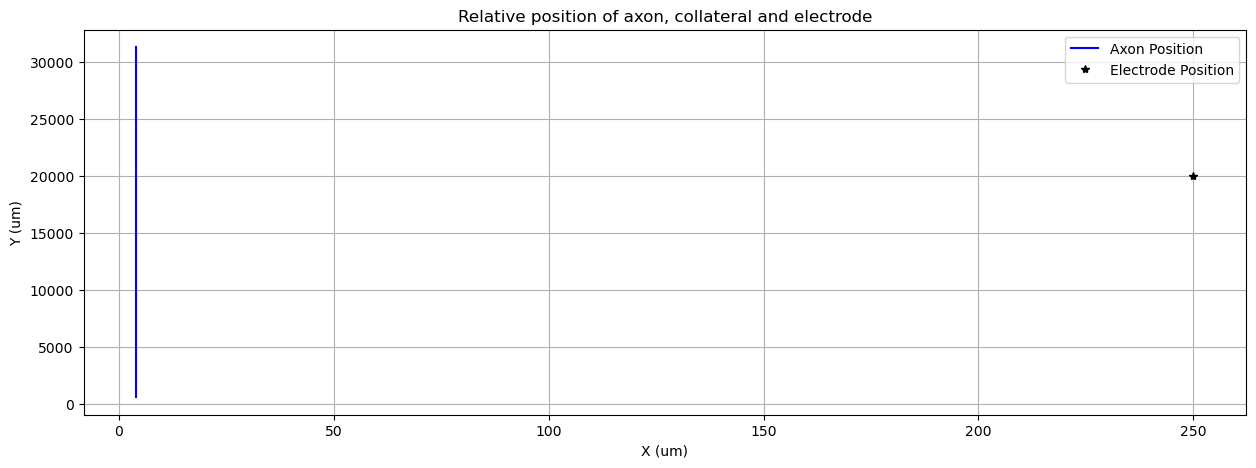

Axon- Firing occurred 1.0 times at: 87.12500000001124, for node 0
Axon- Firing occurred 1.0 times at: 86.35000000001106, for node 1
Axon- Firing occurred 1.0 times at: 85.52500000001088, for node 2
Axon- Firing occurred 1.0 times at: 84.67500000001068, for node 3
Axon- Firing occurred 1.0 times at: 83.8750000000105, for node 4
Axon- Firing occurred 1.0 times at: 83.10000000001033, for node 5
No firing occurred.
Axon- Firing occurred 1.0 times at: 83.4000000000104, for node 7
Axon- Firing occurred 1.0 times at: 84.17500000001057, for node 8
Axon- Firing occurred 1.0 times at: 84.80000000001071, for node 9
AIS- Firing occurred 1.0 times at: 87.12500000001124, for segment 0
AIS- Firing occurred 1.0 times at: 87.12500000001124, for segment 1
AIS- Firing occurred 1.0 times at: 87.12500000001124, for segment 2
AIS- Firing occurred 1.0 times at: 87.12500000001124, for segment 3
AIS- Firing occurred 1.0 times at: 87.12500000001124, for segment 4


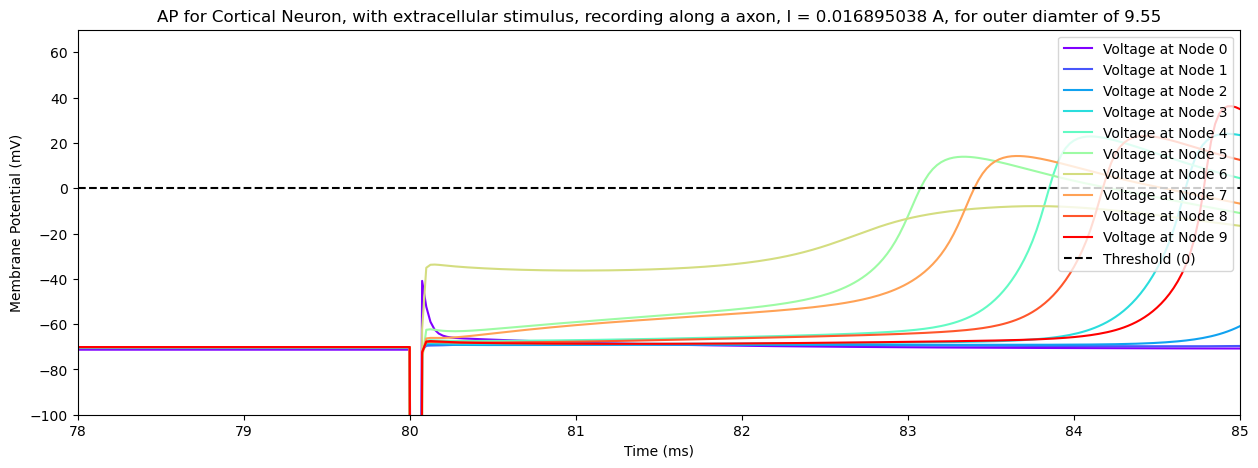

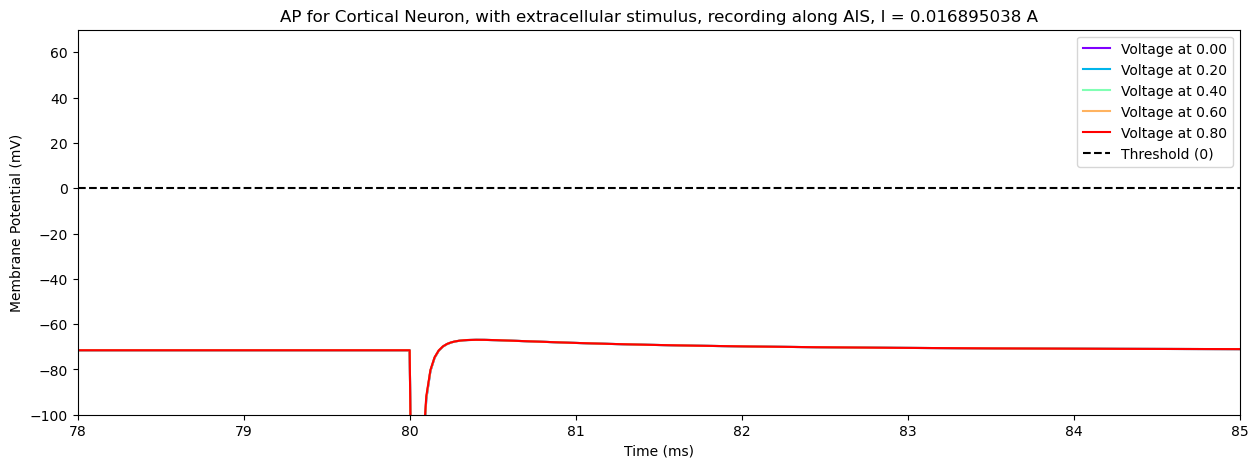

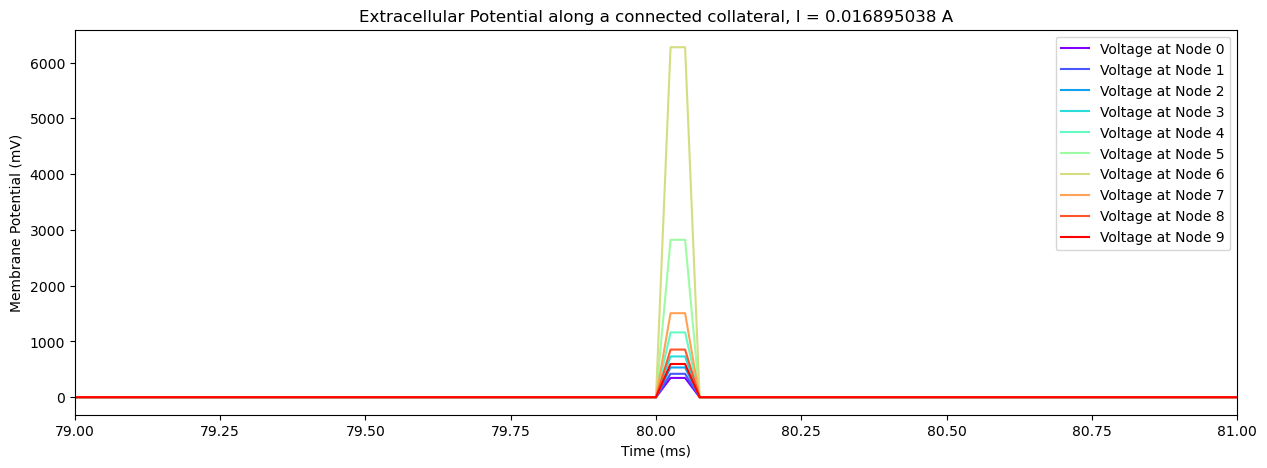

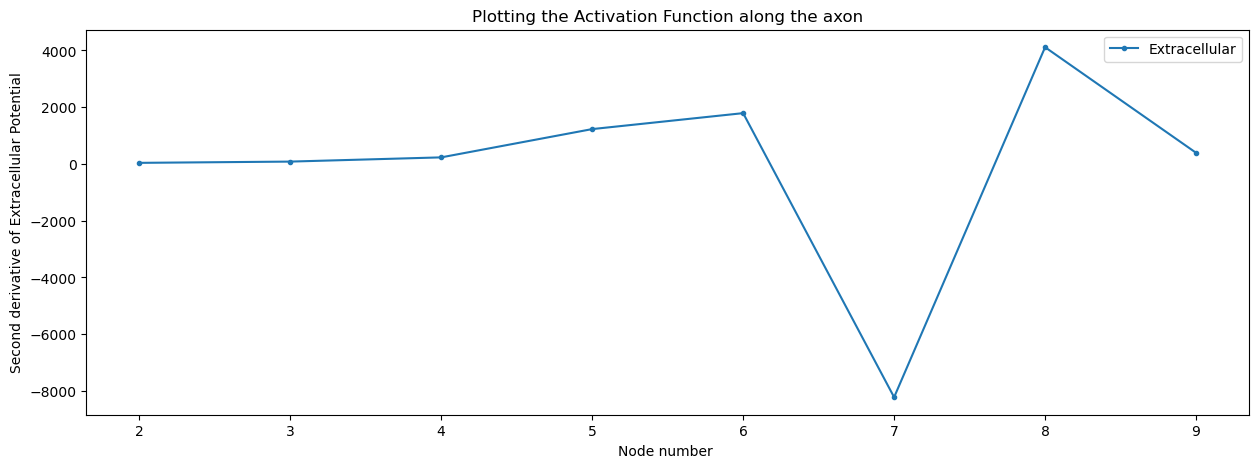

10


In [5]:
import matplotlib.cm as cm
#Simulation set up
h.tstop =100 #simulation duration t1 +pulse_dur + t5, delay = 80 ms
h.celsius = 37 #temperature (in celsius)
h.finitialize(-68) #initialise simulation 
Total_length=32731
idx = -2 #access 3rd last element
M_diam=Myelin_Diameters[idx]
N_diam=Node_Diameters[idx]
int_length=Lengths[idx]
m0_L= ML[idx]
Nseg_AIS =5
cur=0.016895038
amp_A=cur
delay=80
pulse_dur=60*(10**-3)
total_dur=100
Electrode_X_d=250
Electrode_Y_d=20000
TH=0
C = Cortical_Neuron(Total_length, M_diam, N_diam, int_length,m0_L)
[ampvec_allnodes_A, ampvec_allnodes_AIS, stimtvec_A, stimtvec_AIS] = C.Extracellular(amp_A, delay, pulse_dur, total_dur, Electrode_X_d, Electrode_Y_d)
min_prominence = 10 #10mV
t = C.Record_time()
for i in range(C.node_num):
    C.record_voltage_axon(i)
    C.Insert_Counter_Axon(i,TH)
    C.record_ex_potential(i)

for k in range(Nseg_AIS):
    C.record_voltage_AIS(k)
    C.Insert_Counter_AIS(k, TH)
     
plt.figure(figsize=(15, 5))
[y_coords_A, x_coords_A] = C.Plot_Geometry(Electrode_X_d, Electrode_Y_d)

# # Create a DataFrame
#df_Axon = pd.DataFrame({'Axon_X': x_coords_A, 'Axon_Y': y_coords_A})
# df_Collateral = pd.DataFrame({'Collateral_X': x_coords_C, 'Collateral_Y': y_coords_C})
# # Concatenate DataFrames 
# df_Coords = pd.concat([df_Axon, df_Collateral], axis=1)
# #save to excel
# excel_path = "C:\\Users\\laura\\Documents\\NEURON Code\\Python interfaced Neuron\\Long_Axon_Coordinates_Diam3.xlsx"  # Adjust path for your environment
# df_Axon.to_excel(excel_path, index=False)


#Run the simulation
h.run()

for i in range(C.node_num):
    C.get_Fire_count_Axon(i)

for k in range(Nseg_AIS):
    C.get_Fire_count_AIS(k)

colors = cm.rainbow(np.linspace(0, 1, Nseg_AIS))  # Create a list of colors
labels = [f'Voltage at {seg/Nseg_AIS:.2f}' for seg in range(Nseg_AIS)]  # List of labels
colors2 = cm.rainbow(np.linspace(0, 1, C.node_num))  # Create a list of colors
labels2 = [f'Voltage at Node {n}' for n in range(C.node_num)]  # List of labels

plt.figure(figsize=(15, 5))
for n in range(C.node_num):
    va = C.get_voltage_axon(n) 
    plt.plot(t, va, color=colors2[n], label=labels2[n])
    spike_count = C.Firing_Count_Axon[n]
    spike_times = C.Firing_Times_Axon[n]
    if spike_count == 0:
        print("No firing occurred.")
    else:
        print(f"Axon- Firing occurred {spike_count} times at: {spike_times}, for node {n}")
        
plt.axhline(y=TH, color='black', linestyle='--', label=f'Threshold ({TH})')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'AP for Cortical Neuron, with extracellular stimulus, recording along a axon, I = {amp_A} A, for outer diamter of {M_diam}') 
plt.legend(loc='upper right')
plt.xlim([78, 85])
plt.ylim([-100, 70])

plt.figure(figsize=(15, 5))
for seg in range(Nseg_AIS):
    vais = C.get_voltage_ais(seg)  # Corrected from i to seg
    plt.plot(t, vais, color=colors[seg], label=labels[seg])
    spike_count = C.Firing_Count_AIS[seg]
    spike_times = C.Firing_Times_AIS[seg]
    if spike_count == 0:
        print("No firing occurred.")
    else:
        print(f"AIS- Firing occurred {spike_count} times at: {spike_times}, for segment {seg}")
        
plt.axhline(y=TH, color='black', linestyle='--', label=f'Threshold ({TH})')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'AP for Cortical Neuron, with extracellular stimulus, recording along AIS, I = {amp_A} A') 
plt.legend(loc='upper right')
plt.xlim([78, 85])
plt.ylim([-100, 70])

####extracellular potential and activation function 

Ee_axon = []
plt.figure(figsize=(15, 5))
for i in range(C.node_num):
    va_ex = C.get_ex_axon(i)  
    plt.plot(t, va_ex, color=colors2[i], label=labels2[i])
    Ee_axon.append(va_ex)

plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'Extracellular Potential along a connected collateral, I = {amp_A} A') 
plt.legend(loc='upper right')
plt.xlim([79, 81])

# Convert stim time (80 ms) to sample
tn = 3201

ev = np.array([e[tn] for e in Ee_axon])
L = len(ev)
second_derivative = np.diff(np.diff(ev))
# Second derivative of the extracellular potential Activation function
plt.figure(figsize=(15, 5))
plt.plot(np.arange(2, L), second_derivative, ".-")
plt.title('Plotting the Activation Function along the axon')
plt.xlabel('Node number ')
plt.ylabel('Second derivative of Extracellular Potential')
plt.legend(["Extracellular"], loc='upper right')
plt.show()
# print(len(Ee_axon))
# Nodes = np.arange(2, L)
# df_AF = pd.DataFrame({'Nodes': Nodes, 'EX': second_derivative})
# excel_path2 = "C:\\Users\\laura\\Documents\\NEURON Code\\Python interfaced Neuron\\AF_Diam3.xlsx"  # Adjust path for your environment
# df_AF.to_excel(excel_path2, index=False)

# [r_A, r_AIS, y_coords_A, Node_radius, Electrode_X_d, Electrode_Y_d]=C.Coordinates( Electrode_X_d, Electrode_Y_d)
# plt.figure(figsize=(15, 5))


del C
